In [1]:
import json
with open("config.json") as json_file:
    parameter = json.load(json_file)

# Load dataset

In [2]:
import numpy as np
import pickle


with open(parameter["SAVE_DIR"]+"TCC_matrix.dat", 'rb') as f:
    T=pickle.load(f)
with open(parameter["SAVE_DIR"]+"pwise_dist_L1.dat", 'rb') as f:
    D_l1=pickle.load(f)
with open(parameter["SAVE_DIR"]+"nonzero_ec.dat", 'rb') as f:
    nonzero_ec=pickle.load(f)

ecfile_dir = parameter["kallisto"]["TCC_output"]+'/matrix.ec'
eclist=np.loadtxt(ecfile_dir,dtype=str)    

from sklearn.preprocessing import normalize

T_norm = normalize(T, norm='l1', axis=0) 
T_normT = T_norm.transpose()
    
NUM_OF_CELLS=np.shape(T)[1]
print("NUM_OF_CELLS =", NUM_OF_CELLS
)print("NUM_OF_nonzero_EC =", np.shape(T)[0])

NUM_OF_CELLS = 1331
NUM_OF_nonzero_EC = 306789


In [3]:
EC_dict = {}
for i in range(np.shape(eclist)[0]):
    EC_dict[i] = [int(x) for x in eclist[i,1].split(',')]
    
union=set()
for i in nonzero_ec:
    new = [tx for tx in EC_dict[i] if tx not in union] # filter out previously seen transcripts
    union.update(new) 
union_list=list(union) #union of all transctipt ids seen in nonzero eq.classes
NUM_OF_TX_inTCC = len(union)
print("NUM_OF_Transcripts =", NUM_OF_TX_inTCC #number of distinct transcripts in nonzero eq. classes )

NUM_OF_Transcripts = 183429


### Inspect

In [4]:
#sort eq. classes based on size
size_of_ec = [len(EC_dict[i]) for i in nonzero_ec]
ec_idx = [i[0] for i in sorted(enumerate(size_of_ec), key=lambda x:x[1])]
index_ec = np.array(ec_idx)

ec_sort_map={}
nonzero_ec_srt=[]; #init
for i in range(len(nonzero_ec)):
    nonzero_ec_srt+=[nonzero_ec[index_ec[i]]]
    ec_sort_map[nonzero_ec[index_ec[i]]] = i
nonzero_ec_srt = np.array(nonzero_ec_srt)

ec_size_sort=np.array(size_of_ec)[index_ec]
sumi = np.array(T.sum(axis=1))
sumi_sorted=sumi[index_ec]
total_num_of_umis = int(sumi_sorted.sum())
total_num_of_umis_per_cell = np.array(T.sum(axis=0))[0,:]

print("Total number of UMIs =", total_num_of_umis)

Total number of UMIs = 50818692


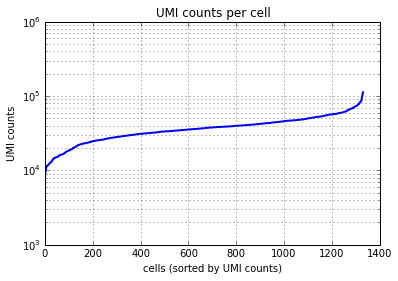

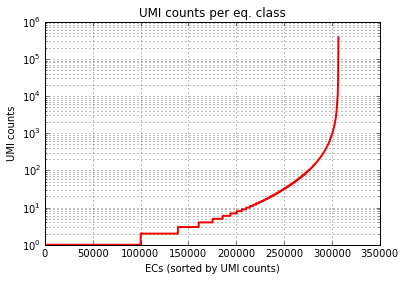

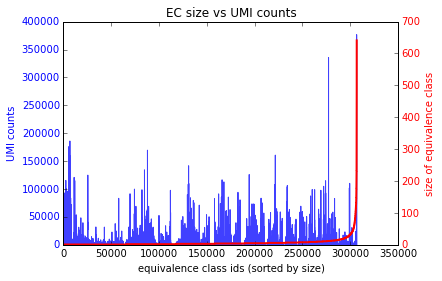

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot(sorted(total_num_of_umis_per_cell), 'b-',linewidth=2.0)
ax1.set_title('UMI counts per cell')
ax1.set_xlabel('cells (sorted by UMI counts)')
ax1.set_ylabel('UMI counts')
ax1.set_yscale("log", nonposy='clip')
# ax1.set_xscale("log", nonposy='clip')
ax1.grid(True)
ax1.grid(True,'minor')


fig, ax1 = plt.subplots()
ax1.plot(sorted(sumi.reshape(np.shape(sumi)[0])), 'r-',linewidth=2.0)
ax1.set_title('UMI counts per eq. class')
ax1.set_xlabel('ECs (sorted by UMI counts)')
ax1.set_ylabel('UMI counts')
ax1.set_yscale("log", nonposy='clip')
# ax1.set_xscale("log", nonposy='clip')
ax1.grid(True)
ax1.grid(True,'minor')


fig, ax1 = plt.subplots()
ax1.plot(sumi_sorted, 'b-', alpha=0.75)
ax1.set_title('EC size vs UMI counts')
ax1.set_xlabel('equivalence class ids (sorted by size)')
ax1.set_ylabel('UMI counts', color='b')
# ax1.set_xlim([0,620000])
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()

ax2.plot(ec_size_sort, 'r',linewidth=2.0)
ax2.set_ylabel('size of equivalence class', color='r')
# ax2.set_xlim([0,620000])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

# Clustering

In [6]:
from sklearn import cluster,manifold
import matplotlib.pyplot as plt
%matplotlib inline

def AffinityProp(D,pref,damp):
    aff= cluster.AffinityPropagation(affinity='precomputed',
                                     preference=pref,damping=damp, verbose=True)
    labels=aff.fit_predict(D)
    return labels

def spectral(k,D):
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels

def tSNE_pairwise(D):
    tsne = manifold.TSNE(n_components=2, random_state=213, metric='precomputed', n_iter=2000, verbose=1);
    X_tsne = tsne.fit_transform(D);
    return X_tsne

In [7]:
X_tsne=tSNE_pairwise(D_l1)

[t-SNE] Computed conditional probabilities for sample 1000 / 1331
[t-SNE] Computed conditional probabilities for sample 1331 / 1331
[t-SNE] Mean sigma: 0.091349
[t-SNE] Error after 66 iterations with early exaggeration: 23.673013
[t-SNE] Error after 134 iterations: 1.935267


In [8]:
# Plot function with (nonrandom) colors corresponding to labels (star a specific label)
def stain_plot(X,labels,stain,title,nc=2):
    unique_labels = np.unique(labels)
    N = len(unique_labels)
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]    
    color= [(int(i[:2], 16)/float(255), int(i[2:4], 16)/float(255), 
             int(i[4:], 16)/float(255)) for i in colors]
    i=0;
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        if label in stain: 
            plt.scatter(X[ind,0],X[ind,1],c='red',s=146,edgecolor='black',
                        lw = 0.5, alpha=1,marker='*',label=label)
        else:
            plt.scatter(X[ind,0],X[ind,1],c=color[i],s=36,edgecolor='lightgray',
                        lw = 0.5,label=label)        
        i+=1   
    plt.title(title)
    plt.legend(loc='upper right',bbox_to_anchor=(1.18, 1.01),ncol=nc)
#     plt.xlim([-20,20])
#     plt.ylim([-20,20])
    plt.axis('off')

In [9]:
labels_2 = spectral(2,D_l1.max()-D_l1)

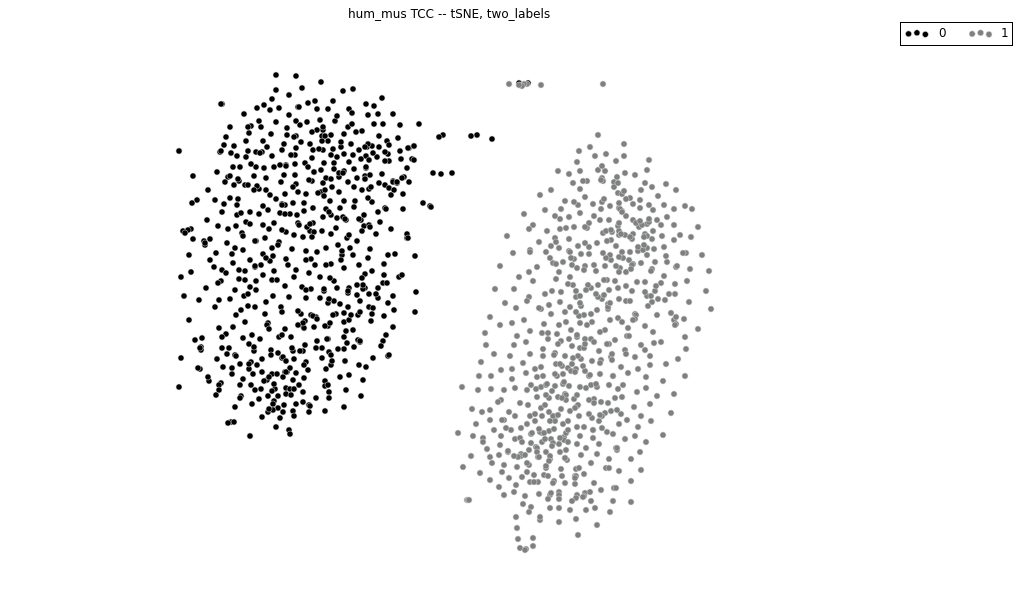

In [11]:
stain_plot(X_tsne,labels_2,[],"hum_mus TCC -- tSNE, two_labels")

In [12]:
pref = -np.median(D_l1)*np.ones(NUM_OF_CELLS)
labels_aff=AffinityProp(-D_l1,pref,0.5)
np.unique(labels_aff)

Converged after 28 iterations.


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

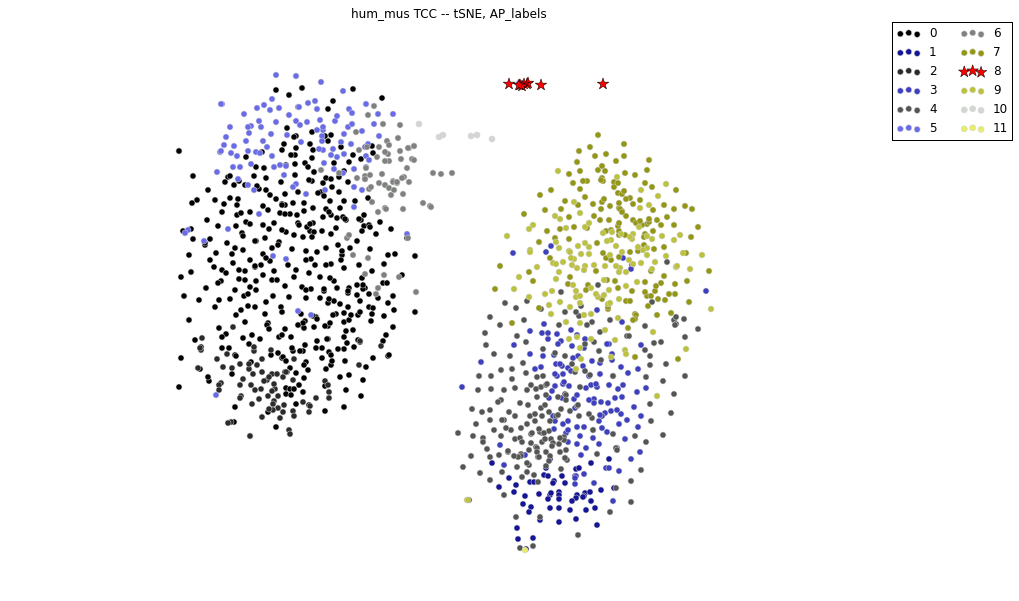

In [13]:
stain_plot(X_tsne,labels_aff,[8],"hum_mus TCC -- tSNE, affinity propagation labels")

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(T_normT.todense())

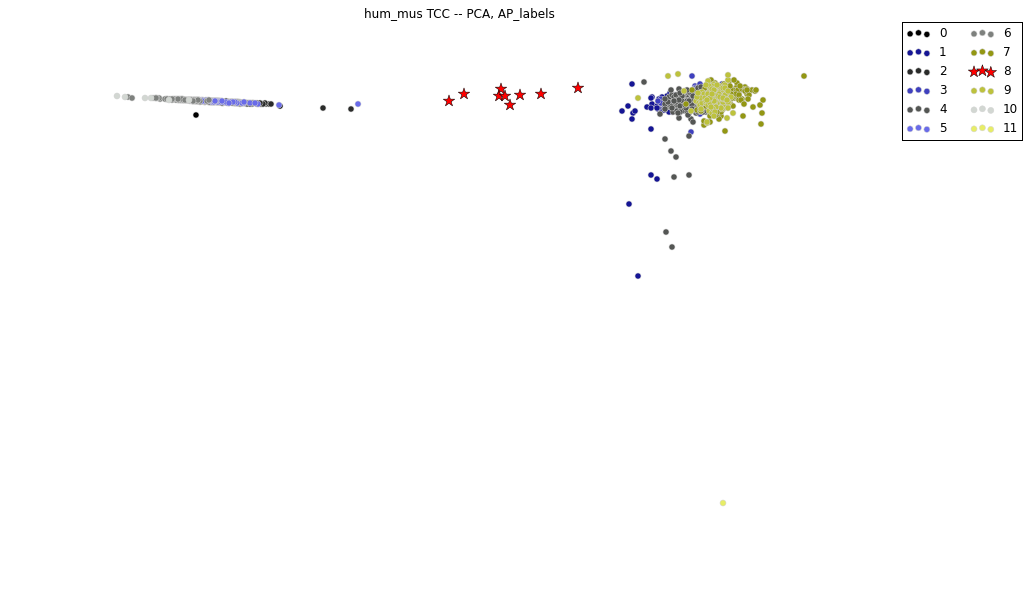

In [15]:
stain_plot(X_pca,labels_aff,[8],"hum_mus TCC -- PCA, affinity propagation labels")

### Human-mouse plot

In [16]:
# path to human mouse transcriptome:
hummus_tx = '/path/to/Mus_musculus.GRCm38.rel79_Homo_sapiens.GRCh38.rel79.cdna.mix.fa'

In [17]:
count = 0
flag=0
with open(hummus_tx) as f:
    for line in f:
        if line[0]=='>':
            if line[:5]!=">ENSM" and flag==0:
                hum_ind = count
                #print(count, line
)                flag=1
            count+=1

In [18]:
human_ec =[]  # eq. classes that correspond only to human (contain only human transcripts)
mouse_ec = [] # eq. classes that correspond only to mouse
joint_ec =[]  # mixed eq. classes (both human and mouse transcripts)


for ec in nonzero_ec:
    if all(i >= hum_ind for i in EC_dict[ec]):
        human_ec += [ec]
    elif all(i < hum_ind for i in EC_dict[ec]):
        mouse_ec += [ec]
    else:
        joint_ec += [ec]
    

In [19]:
hum_ec_idx=[]
mouse_ec_idx= []
joint_ec_idx= []

sethuman=set(human_ec)
setmouse=set(mouse_ec)

for i,ec in enumerate(nonzero_ec):
    if ec in sethuman: 
        hum_ec_idx+=[i]
    elif ec in setmouse:
        mouse_ec_idx+=[i]
    else: joint_ec_idx+=[i]
        

In [20]:
mouse_ = np.array(T[np.array(mouse_ec_idx),:].sum(axis=0))[0,:]
human_ = np.array(T[np.array(hum_ec_idx),:].sum(axis=0))[0,:]

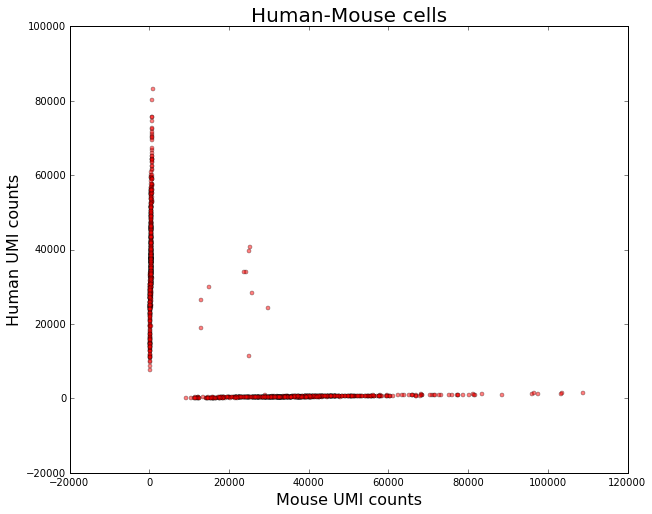

In [21]:
plt.figure(figsize=(10,8))
plt.xlabel("Mouse UMI counts",fontsize=16)
plt.ylabel("Human UMI counts",fontsize=16)
plt.title("Human-Mouse cells",fontsize=20)
for cell in range(len(human_)):
    plt.scatter(mouse_[cell],human_[cell],c='red',s=16,edgecolors='black',
                        lw = 0.5, alpha=.5,marker='o')
